### Homework Assignment (Denoising Autoencoder)

Im based on the work published in kaggle by Aakash Nain 
 https://www.kaggle.com/aakashnain/denoising-autoencoders-to-the-rescue/notebook (credits for their great work) to solve a homework assigment of Datalit (https://www.theschool.ai/courses/data-lit ). From this I made some other experiments with different configurations, particularly using a different optimizer algorithm and the same Adam algorithim but with more epochs (20,30) and a more bigger batch size , to take advantage of google colab GPU.It can be noted that the main idea of this notebook is try to understand the functionality of the autoencoders and their possible applications and not to go deeper.    
 By: Fernando Chica


In [1]:
# Firts mount my google drive in colab

from google.colab import drive

# Montar carpeta de google Drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
# Import some importante libraries

import os
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
from sklearn.model_selection import train_test_split
np.random.seed(111)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls"]).decode("utf8"))
# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


drive
sample_data



In [0]:
# Now we define all the directories in Gdrive, of the dataset

input_dir  = ('drive/My Drive/Data_LIT/denoising-dirty-documents')
train = input_dir +'/train'
train_cleaned = input_dir + '/train_cleaned'
test = input_dir + '/test'

In [34]:
samples

['101.png', '102.png', '104.png', '105.png']

Total number of images in the training set:  144
Total number of cleaned images found:  144
Total number of samples in the test set:  72


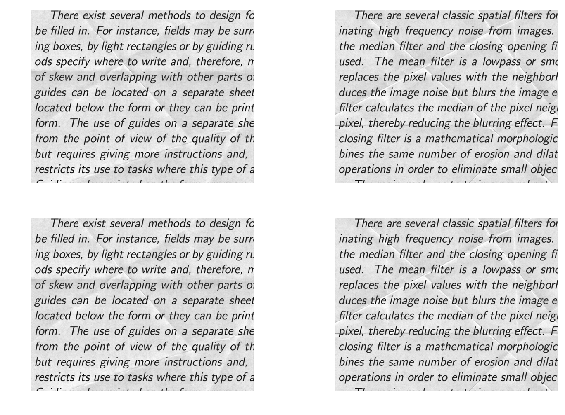

In [50]:
# Next, check if the directories work well and shown some samples

train_images = sorted(os.listdir(train))
train_labels = sorted(os.listdir(train_cleaned))
test_images = sorted(os.listdir(test))
print("Total number of images in the training set: ", len(train_images))
print("Total number of cleaned images found: ", len(train_labels))
print("Total number of samples in the test set: ", len(test_images))

# Samples

samples = train_images[:2] + train_labels[:2]
s1='/'

f, ax = plt.subplots(2, 2, figsize=(10,7))
for i, img in enumerate(samples):
    img = imread(train+s1+img)
    ax[i//2, i%2].imshow(img, cmap='gray')
    ax[i//2, i%2].axis('off')
    
plt.show()    

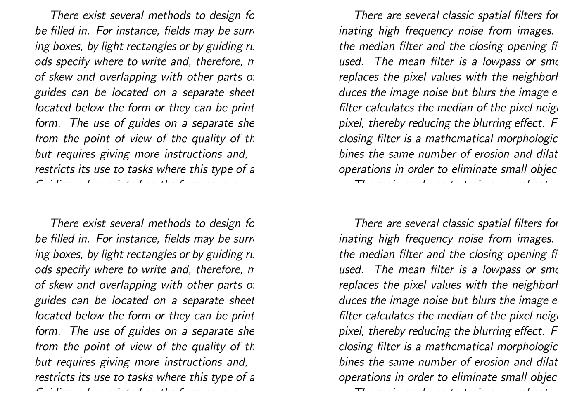

In [51]:
# The cleaned samples

f, ax = plt.subplots(2, 2, figsize=(10,7))
for i, img in enumerate(samples):
    img = imread(train_cleaned+s1+img)
    ax[i//2, i%2].imshow(img, cmap='gray')
    ax[i//2, i%2].axis('off')

In [0]:
# This is the structure of the autoencoder, can be noticed the bottleneck in 
# the middle 

def build_autoenocder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #encoder 
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    
    #decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='sgd', loss='binary_crossentropy')
    return autoencoder

In [5]:
#We can see a summary of our autoencoder defined in this case we use the Stochastic Gradient Descent algorithm (sgd) as optimizer

autoencoder = build_autoenocder()
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 420, 540, 1)       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 420, 540, 32)      320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 210, 270, 32)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 210, 270, 64)      18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 105, 135, 64)      0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 105, 135, 64)      36928     
_________________________________________________________________
upsa

I followed the strategy of Aakash Nain due to the small dataset. So I used lot numpy arrays that contains all the images.

In [6]:
X = []
Y = []

for img in train_images:
    img = load_img(train +s1+ img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img in train_labels:
    img = load_img(train_cleaned +s1+ img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)


X = np.array(X)
Y = np.array(Y)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Size of X :  (144, 420, 540, 1)
Size of Y :  (144, 420, 540, 1)


In [0]:
# After the training phase, lest split the dataset.

X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)


In [9]:
# Train the model

autoencoder.fit(X_train, y_train, epochs=30, batch_size=20, validation_data=(X_valid, y_valid))

Instructions for updating:
Use tf.cast instead.
Train on 129 samples, validate on 15 samples
Epoch 1/30
129/129 [==============================] - 144s 1s/step - loss: 0.6445 - val_loss: 0.5750
Epoch 2/30
129/129 [==============================] - 144s 1s/step - loss: 0.5301 - val_loss: 0.4677
Epoch 3/30
129/129 [==============================] - 143s 1s/step - loss: 0.4300 - val_loss: 0.3904
Epoch 4/30
129/129 [==============================] - 143s 1s/step - loss: 0.3712 - val_loss: 0.3629
Epoch 5/30
129/129 [==============================] - 143s 1s/step - loss: 0.3536 - val_loss: 0.3574
Epoch 6/30
129/129 [==============================] - 143s 1s/step - loss: 0.3498 - val_loss: 0.3562
Epoch 7/30
129/129 [==============================] - 142s 1s/step - loss: 0.3488 - val_loss: 0.3556
Epoch 8/30
129/129 [==============================] - 143s 1s/step - loss: 0.3481 - val_loss: 0.3551
Epoch 9/30
129/129 [==============================] - 142s 1s/step - loss: 0.3477 - val_loss: 0.354

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


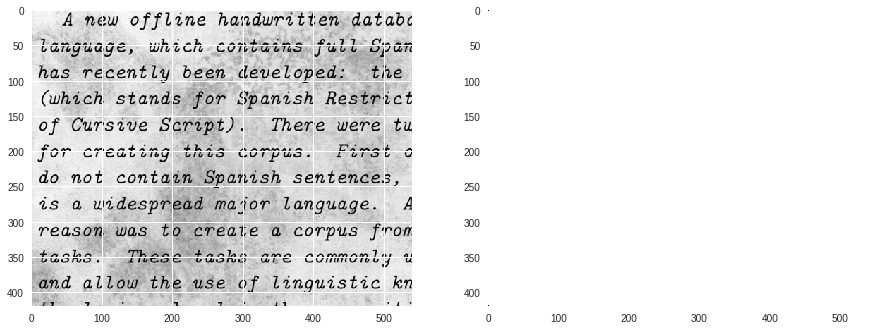

In [15]:
# With the model trainied we see the results on and image

sample_test = load_img(test +s1+test_images[11], grayscale=True, target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)


predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(15,16))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()

In this case the image resultant doesn't satisfy our requirement, in fact the model erase all the image as if all is noise xD (it's the first test so) , so next there are others experiments to improve this results.

In [0]:
# Now we define the autoencoder but using the Adam optimizer

def build_autoenocder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #enoder 
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    
    #decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

In [17]:
autoencoder = build_autoenocder()
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 420, 540, 1)       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 420, 540, 32)      320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 210, 270, 32)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 210, 270, 64)      18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 105, 135, 64)      0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 105, 135, 64)      36928     
_________________________________________________________________
upsample1 (UpSampling2D)     (None, 210, 270, 64)      0         
__________

In [19]:
# Train the model with the new optimizer

autoencoder.fit(X_train, y_train, epochs=20, batch_size=20, validation_data=(X_valid, y_valid))

Train on 129 samples, validate on 15 samples
Epoch 1/20
129/129 [==============================] - 142s 1s/step - loss: 0.5268 - val_loss: 0.4305
Epoch 2/20
129/129 [==============================] - 141s 1s/step - loss: 0.4029 - val_loss: 0.3742
Epoch 3/20
129/129 [==============================] - 141s 1s/step - loss: 0.3720 - val_loss: 0.3594
Epoch 4/20
129/129 [==============================] - 142s 1s/step - loss: 0.3543 - val_loss: 0.3527
Epoch 5/20
129/129 [==============================] - 141s 1s/step - loss: 0.3433 - val_loss: 0.3380
Epoch 6/20
129/129 [==============================] - 141s 1s/step - loss: 0.3224 - val_loss: 0.3122
Epoch 7/20
129/129 [==============================] - 141s 1s/step - loss: 0.2933 - val_loss: 0.2773
Epoch 8/20
129/129 [==============================] - 142s 1s/step - loss: 0.2620 - val_loss: 0.2562
Epoch 9/20
129/129 [==============================] - 142s 1s/step - loss: 0.2480 - val_loss: 0.2505
Epoch 10/20
129/129 [=========================

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


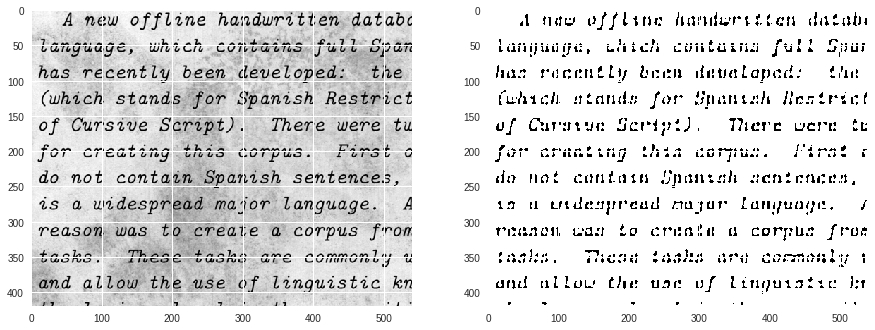

In [20]:
# Plot the results 


sample_test = load_img(test +s1+test_images[11], grayscale=True, target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(15,16))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()

Now the results are better and we are in the right way, so next we try with a more epochs to improve their results.

In [21]:
autoencoder = build_autoenocder()

autoencoder.fit(X_train, y_train, epochs=30, batch_size=20, validation_data=(X_valid, y_valid))

Train on 129 samples, validate on 15 samples
Epoch 1/30
129/129 [==============================] - 143s 1s/step - loss: 0.4881 - val_loss: 0.4329
Epoch 2/30
129/129 [==============================] - 143s 1s/step - loss: 0.3791 - val_loss: 0.3699
Epoch 3/30
129/129 [==============================] - 143s 1s/step - loss: 0.3525 - val_loss: 0.3528
Epoch 4/30
129/129 [==============================] - 144s 1s/step - loss: 0.3347 - val_loss: 0.3278
Epoch 5/30
129/129 [==============================] - 144s 1s/step - loss: 0.3083 - val_loss: 0.2918
Epoch 6/30
129/129 [==============================] - 143s 1s/step - loss: 0.2704 - val_loss: 0.2575
Epoch 7/30
129/129 [==============================] - 144s 1s/step - loss: 0.2472 - val_loss: 0.2471
Epoch 8/30
129/129 [==============================] - 143s 1s/step - loss: 0.2376 - val_loss: 0.2408
Epoch 9/30
129/129 [==============================] - 144s 1s/step - loss: 0.2279 - val_loss: 0.2306
Epoch 10/30
129/129 [=========================

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


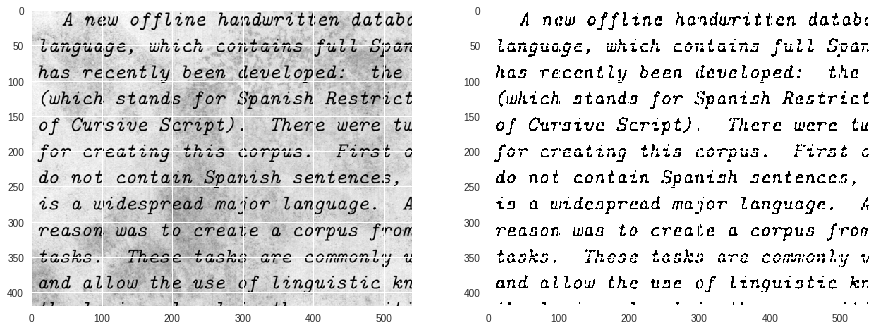

In [22]:
# Let's test our model on a sample test image
sample_test = load_img(test +s1+test_images[11], grayscale=True, target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the predition
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(15,16))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()

Now the results are quite good, the next step is go deeper but for now we fulfil the main idea. Again thanks for the great contribution of Aakash Nain and to the people behind the datalit course. :D